In [1]:
using Plots, LaTeXStrings
gr()
#inline()
using LinearAlgebra
using Base.Threads
using Distributed
@everywhere using SharedArrays
addprocs(Sys.CPU_THREADS - 1)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
@everywhere function pointsDelaunay(dimBase::Float64, dim::Int64)
    points = rand(dim, 2)
    if dimBase != 1.0
        points[:,2] /= dimBase
    end
    n, tri = GR.delaunay(points[:,1], points[:,2])
    n, tri, points
end

@everywhere function triDelaunay(points)
    n, tri = GR.delaunay(points[:,1], points[:,2])
    n, tri, points
end

@everywhere function rcentersGeqOneLune(beta::Float64, x1::Float64, y1::Float64, x2::Float64, y2::Float64)
    c1 = [beta.*x1./2.0 .+ (1.0 .- beta./2).*x2 beta.*y1./2.0 .+ (1.0 .- beta./2.0).*y2]
    c2 = [(1.0 .- beta./2.0).*x1 .+ beta.*x2./2.0 (1.0 .- beta./2).*y1 .+ beta.*y2./2]
    r = beta.*sqrt((x2 .- x1).^2 + (y2 .- y1).^2)./2.0
    r, c1, c2
end

@everywhere function rcentersLeqOne(beta::Float64, x1::Float64, y1::Float64, x2::Float64, y2::Float64)
    dot_v1 = [x1, y1]
    dot_v2 = [x2, y2]
    vec_v1v2 = dot_v2 .- dot_v1
    rotvec = reverse(vec_v1v2).*[-1,1]
    radOut = sqrt.(sum(vec_v1v2.^2))./(2*beta)
    b_out = sqrt.(1 .- beta^2)./(2*beta)
    p_c1 = (dot_v1 .+ dot_v2)./2 .+ b_out.*rotvec
    p_c2 = (dot_v1 .+ dot_v2)./2 .- b_out.*rotvec
    radOut, p_c1', p_c2'
end

@everywhere function rcentersGeqOneCircle(beta::Float64, x1::Float64, y1::Float64, x2::Float64, y2::Float64)
    dot_v1 = [x1, y1]
    dot_v2 = [x2, y2]
    vec_v1v2 = dot_v2 .- dot_v1
    rotvec = reverse(vec_v1v2).*[-1,1]
    radOut = beta.*sqrt.(sum(vec_v1v2.^2))./2
    b_out = sqrt.(beta^2 .- 1)./2
    p_c1 = (dot_v1 .+ dot_v2)./2 .+ b_out.*rotvec
    p_c2 = (dot_v1 .+ dot_v2)./2 .- b_out.*rotvec
    radOut, p_c1', p_c2'
end


function betaRandSkeletonGeqOneLune(beta::Float64, dim::Int64, plotSkeleton = false, dimBase::Float64 = 1.0)
    n, tri, points = pointsDelaunay(dimBase, dim)
    mAdjacency = SharedArray{Float64}(diagm(0 => rand(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneLune(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= 0
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaRandSkeletonGeqOneCircle(beta::Float64, dim::Int64, plotSkeleton = false, dimBase::Float64 = 1.0)
    n, tri, points = pointsDelaunay(dimBase, dim)
    mAdjacency = SharedArray{Float64}(diagm(0 => rand(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneCircle(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            #full_1[[indx1, indx2]] .= 0
            #full_2[[indx1, indx2]] .= 0
            if any(full_1 .| full_2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end


function betaRandSkeletonLeqOne(beta::Float64, dim::Int64, plotSkeleton = false, dimBase::Float64 = 1.0)
    mAdjacency = SharedArray{Float64}(diagm(0 => rand(dim)))
    points = rand(dim, 2)
    if dimBase != 1.0
        points[:,2] /= dimBase
    end
    @sync @distributed for indx1 in 1:dim-1
        for indx2 in indx1 + 1:dim
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersLeqOne(beta, x1, y1, x2, y2)
            full_1 = sqrt.(sum((points .- c1).^2, dims = 2)) .< r
            full_2 = sqrt.(sum((points .- c2).^2, dims = 2)) .< r
            full_1[[indx1, indx2]] .= 0
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end    
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaSkeletonGeqOneLune(beta::Float64, points, plotSkeleton = false)
    n, tri, points = triDelaunay(points)
    dim = length(points[:,1])
    mAdjacency = SharedArray{Float64}(diagm(0 => rand(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneLune(beta, x1, y1, x2, y2)
            full_1 = round.(sqrt.(sum((points .- c1).^2, dims = 2)), digits = 12) .< round.(r,digits = 12)
            full_2 = round.(sqrt.(sum((points .- c2).^2, dims = 2)), digits = 12) .< round.(r, digits = 12)
            full_1[[indx1, indx2]] .= 0
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaSkeletonGeqOneCircle(beta::Float64, points, plotSkeleton = false)
    n, tri, points = triDelaunay(points)
    dim = length(points[:,1])
    mAdjacency = SharedArray{Float64}(diagm(0 => rand(dim)))
    indices = [1, 1, 2]
    j = [2, 3, 3]
    @sync @distributed for trindx in 1:n
        for (indx, i) in enumerate(indices)
            indx1 = tri[trindx,:][i]
            indx2 = tri[trindx,:][j[indx]]
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersGeqOneCircle(beta, x1, y1, x2, y2)
            full_1 = round.(sqrt.(sum((points .- c1).^2, dims = 2)), digits = 12) .< round.(r,digits = 12)
            full_2 = round.(sqrt.(sum((points .- c2).^2, dims = 2)), digits = 12) .< round.(r, digits = 12)
            full_1[[indx1, indx2]] .= 0
            full_2[[indx1, indx2]] .= 0
            if any(full_1 .| full_2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = 1.0
                mAdjacency[indx2, indx1] = 1.0 
            end
        end
    end
    plotSkeleton == true ? (mAdjacency, points, tri) : mAdjacency
end

function betaSkeletonLeqOne(beta::Float64, points)
    dim = length(points[:,1])
    mAdjacency = SharedArray{Float64}(diagm(0 => rand(dim)))
    @sync @distributed for indx1 in 1:dim-1
        for indx2 in indx1 + 1:dim
            x1, y1 = points[indx1, :]
            x2, y2 = points[indx2, :]
            r, c1, c2 = rcentersLeqOne(beta, x1, y1, x2, y2)
            full_1 = round.(sqrt.(sum((points .- c1).^2, dims = 2)), digits = 12) .< round.(r, digits = 12)
            full_2 = round.(sqrt.(sum((points .- c2).^2, dims = 2)), digits = 12) .< round.(r, digits = 12)
            full_1[[indx1, indx2]] .= 0
            if any(full_1 .+ full_2 .== 2) == false
                rnd = randn()./sqrt(2)
                mAdjacency[indx1, indx2] = rnd
                mAdjacency[indx2, indx1] = rnd  
            end
        end
    end    
    mAdjacency
end


function plotBetaSkeleton(points, madjacency)
    x, y = points[:,1], points[:,2]
    lowerm = LowerTriangular(madjacency)
    n = length(x)
    p0 = plot(x, y,seriestype=:scatter, m=(3, 0.8, :black, stroke(0)),
        xlim =(0,1), ylim=(0,1), legend = false, grid = false, axis = :on, 
        framestyle=:box, size = (400, 400), aspect_ratio=1)
    for indxp in 1:n
        edges = findall(lowerm[:,indxp] .!= 0)
        for v in edges[2:end]
            plot!(x[[indxp, v]], y[[indxp, v]], linewidth = 0.7, linecolor = :black)
        end
    end
    p0
end

function plotDelaunay(points, triplete)
    x, y = points[:,1], points[:,2]
    p1 = plot(xlim =(0,1), ylim=(0,1), legend = false, grid = false, axis = :on, 
        framestyle=:box, size = (400, 400), aspect_ratio=1)
    for i in 1:size(tri)[1]
        plot!(x[triplete[i,:]], y[triplete[i,:]], seriestype = [:shape, :scatter], 
            m = (2, 0.2, :black, stroke(0)), linestyle = :solid,
            linealpha = 0.4, linewidth = 0.7, linecolor = :black, fillalpha = 0.02) #  fillcolor = :false
    end
    p1   
end

function pointsHexagonX(center, size, i)
    angledeg = 60*i #- 30
    anglerad = pi/180*angledeg
    (center[1] .+ size*cos(anglerad), center[2] .+ size*sin(anglerad))
end

pointsHexagonX (generic function with 1 method)

https://www.redblobgames.com/grids/hexagons/

In [3]:
corners = []
centros = [[0,0], [0,sqrt(3)], [0,2*sqrt(3)], [3/2, sqrt(3)/2],[3/2, sqrt(3)+ sqrt(3)/2],
[-3/2, sqrt(3)/2],[-3/2, sqrt(3)+ sqrt(3)/2]]
for center in centros
    for i in 1:6
        push!(corners, round.(pointsHexagonX(center, 1, i), digits = 12))
    end
end

In [4]:
cornersX = [corners[i][1] for i in 1:length(centros)*6]
cornersY = [corners[i][2] for i in 1:length(centros)*6];

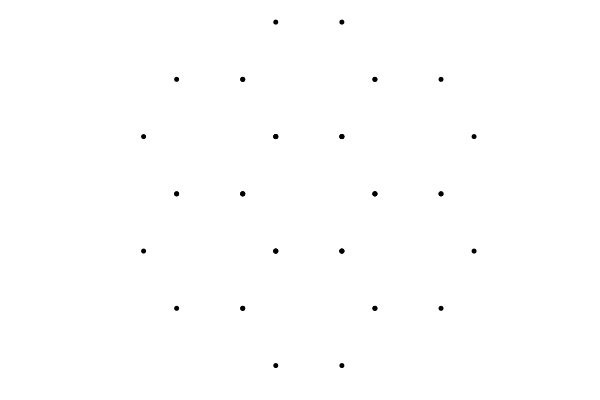

In [5]:
plot(cornersX, cornersY, seriestype = [:scatter], m = (2, :black), aspect_ratio = 1,
    axis = :off, legend = false, grid = false)

In [6]:
puntos = zeros(42,2);

In [7]:
puntos[:,1] = cornersX
puntos[:,2] = cornersY;

In [8]:
function plotBetaSkeleton2(points, madjacency)
    x, y = points[:,1], points[:,2]
    lowerm = LowerTriangular(madjacency)
    n = length(x)
    p0 = plot(x, y,seriestype=:scatter, m=(3, 0.8, :black, stroke(0)),
        xlim =(-3,3), ylim=(-1,4.5), legend = false, grid = false, axis = :on, 
        framestyle=:box, dpi=100, size = (300, 300),
        xtickfont = font(14, "sans-serif"),ytickfont = font(14, "sans-serif"),
    xticks = ([-3,-2,-1,0,1,2,3],[L"-3", L"-2", L"-1",  L"0",  L"1",  L"2",  L"3"]), 
        yticks = ([-1,0,1,2,3,4],[L"-1", L"0", L"1",  L"2",  L"3",  L"4"]),
        aspect_ratio=1)
    for indxp in 1:n
        edges = findall(lowerm[:,indxp] .!= 0)
        for v in edges[2:end]
            plot!(x[[indxp, v]], y[[indxp, v]], linewidth = 0.7, linecolor = :black)
        end
    end
    p0
end

function plotDelaunay2(points, triplete)
    x, y = points[:,1], points[:,2]
    p1 = plot(xlim =(-3,3), ylim=(-1,4.5), legend = false, grid = false, axis = :on, 
        framestyle=:box, dpi=100, size = (300, 300), 
        xtickfont = font(14, "sans-serif"),ytickfont = font(14, "sans-serif"),
    xticks = ([-3,-2,-1,0,1,2,3],[L"-3", L"-2", L"-1",  L"0",  L"1",  L"2",  L"3"]), 
        yticks = ([-1,0,1,2,3,4],[L"-1", L"0", L"1",  L"2",  L"3",  L"4"]),
        aspect_ratio=1)
    for i in 1:size(tri)[1]
        plot!(x[triplete[i,:]], y[triplete[i,:]], seriestype = [:shape, :scatter], 
            m = (2, 0.2, :black, stroke(0)), linestyle = :solid,
            linealpha = 0.4, linewidth = 0.7, linecolor = :black, fillalpha = 0.02) #  fillcolor = :false
    end
    p1   
end

plotDelaunay2 (generic function with 1 method)

In [9]:
puntosN = round.(puntos, digits = 12);

In [10]:
puntosN[puntosN .== -0.0] .= 0.0;

In [11]:
puntosnew = unique(puntosN, dims = 1);

In [12]:
madea, points, tri = betaSkeletonGeqOneLune(1.0, puntosnew, true);

In [13]:
madeaC, pointsC, triC = betaSkeletonGeqOneCircle(1.0, puntosnew, true);

In [14]:
madeainf = betaSkeletonGeqOneLune(100.1, puntosnew);

In [15]:
madeaG = betaSkeletonLeqOne(1.0, points);

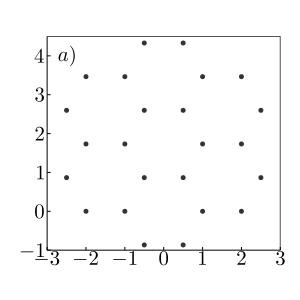

In [16]:
x, y = points[:,1], points[:,2]
honey = plot(x, y,seriestype=:scatter, m=(3, 0.8, :black, stroke(0)),
    xlim =(-3,3), ylim=(-1,4.5), legend = false, grid = false, axis = :on, 
    framestyle=:box, size = (300, 300), xtickfont = font(14, "sans-serif"),ytickfont = font(14, "sans-serif"),
    xticks = ([-3,-2,-1,0,1,2,3],[L"-3", L"-2", L"-1",  L"0",  L"1",  L"2",  L"3"]), 
    yticks = ([-1,0,1,2,3,4],[L"-1", L"0", L"1",  L"2",  L"3",  L"4"]),
    aspect_ratio=1, dpi=100)
honey
annotate!(-2.5, 4.0, text(L"a)", :black, 14))

In [17]:
# note: there is a numerical error for beta = 2, or around 1e-12.... 

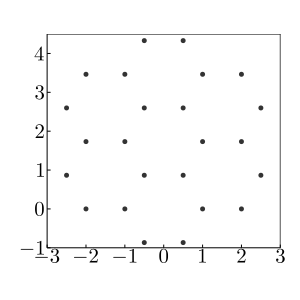

In [18]:
madeaC, pointsC, triC = betaSkeletonGeqOneCircle(2.1, puntosnew, true)
pSkeletonCircle = plotBetaSkeleton2(pointsC, madeaC)

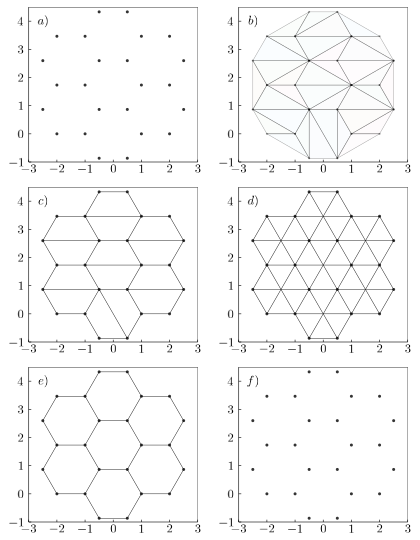

In [19]:
pSkeletonCircle = plotBetaSkeleton2(points, madeaC)
annotate!(-2.5, 4.0, text(L"f)", :black, 14))
pSkeleton = plotBetaSkeleton2(points, madea)
annotate!(-2.5, 4.0, text(L"c)", :black, 14))
pSkeletoninf = plotBetaSkeleton2(points, madeainf)
annotate!(-2.5, 4.0, text(L"e)", :black, 14))
pDelaunay = plotDelaunay2(points, tri)
annotate!(-2.5, 4.0, text(L"b)", :black, 14))
pSkeletonG = plotBetaSkeleton2(points, madeaG)
annotate!(-2.5, 4.0, text(L"d)", :black, 14))
plot(honey, pDelaunay, pSkeleton, pSkeletonG, pSkeletoninf, pSkeletonCircle, 
    layout = (3, 2), legend=false, dpi=60,  size = (700, 900))
#savefig("pDelaunayHoneyAll3.pdf")

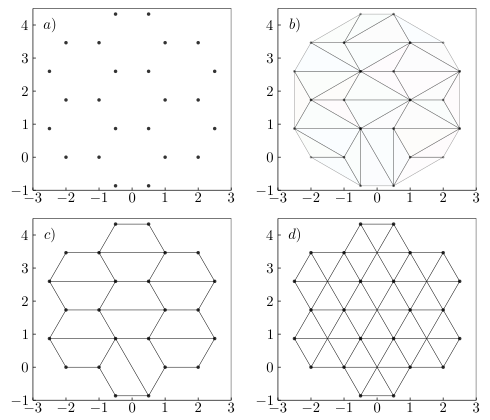

In [33]:
pSkeletonCircle = plotBetaSkeleton2(points, madeaC)
annotate!(-2.5, 4.0, text(L"f)", :black, 14))
pSkeleton = plotBetaSkeleton2(points, madea)
annotate!(-2.5, 4.0, text(L"c)", :black, 14))
pSkeletoninf = plotBetaSkeleton2(points, madeainf)
annotate!(-2.5, 4.0, text(L"e)", :black, 14))
pDelaunay = plotDelaunay2(points, tri)
annotate!(-2.5, 4.0, text(L"b)", :black, 14))
pSkeletonG = plotBetaSkeleton2(points, madeaG)
annotate!(-2.5, 4.0, text(L"d)", :black, 14))
plot(honey, pDelaunay, pSkeleton, pSkeletonG, 
    layout = (2, 2), legend=false, dpi=70,  size = (700, 600))
#savefig("pDelaunayHoneywrong.pdf")

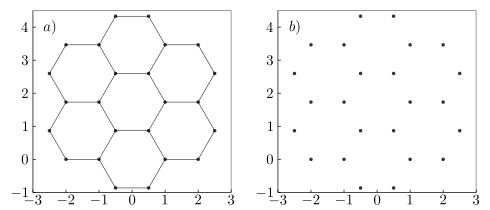

In [35]:
pSkeletonCircle = plotBetaSkeleton2(points, madeaC)
annotate!(-2.5, 4.0, text(L"b)", :black, 14))
pSkeleton = plotBetaSkeleton2(points, madea)
annotate!(-2.5, 4.0, text(L"c)", :black, 14))
pSkeletoninf = plotBetaSkeleton2(points, madeainf)
annotate!(-2.5, 4.0, text(L"a)", :black, 14))
pDelaunay = plotDelaunay2(points, tri)
annotate!(-2.5, 4.0, text(L"b)", :black, 14))
pSkeletonG = plotBetaSkeleton2(points, madeaG)
annotate!(-2.5, 4.0, text(L"d)", :black, 14))
plot( pSkeletoninf, pSkeletonCircle, layout = (1, 2), legend=false, dpi=70,  size = (700, 300))
#savefig("pDelaunayHoneyGood.pdf")

In [50]:
function plotBetaSkeleton3(points, madjacency, titulo)
    x, y = points[:,1], points[:,2]
    lowerm = LowerTriangular(madjacency)
    n = length(x)
    p0 = plot(x, y,seriestype=:scatter, m=(3, 0.8, :black, stroke(0)),
        xlim =(-3,3), ylim=(-1,4.5), legend = false, title = titulo, titlefontsize =12,  grid = false, axis = :on, 
        framestyle=:box, dpi=100, size = (300, 300),
        xtickfont = font(14, "sans-serif"),ytickfont = font(14, "sans-serif"),
    xticks = ([-3,-2,-1,0,1,2,3],[L"-3", L"-2", L"-1",  L"0",  L"1",  L"2",  L"3"]), 
        yticks = ([-1,0,1,2,3,4],[L"-1", L"0", L"1",  L"2",  L"3",  L"4"]),
        aspect_ratio=1)
    for indxp in 1:n
        edges = findall(lowerm[:,indxp] .!= 0)
        for v in edges[2:end]
            plot!(x[[indxp, v]], y[[indxp, v]], linewidth = 0.7, linecolor = :black)
        end
    end
    p0
end

plotBetaSkeleton3 (generic function with 1 method)

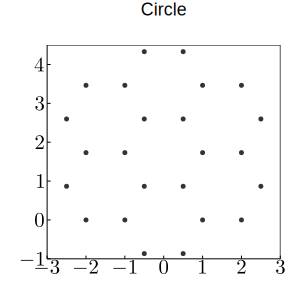

In [51]:
pSkeletonCircle2 = plotBetaSkeleton3(points, madeaC, "Circle")


In [41]:
#savefig("pSkeletonHoney.pdf")

In [208]:
pDelaunay = plotDelaunay2(points, tri)
#savefig("DelaunayHoney.pdf")